In [60]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
import nltk
import string
import numpy as np
import pandas as pd
import os
import fasttext
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM

import fasttext.util
from gensim.models import KeyedVectors


In [61]:
df_raw=pd.read_csv('OffensiveMemes.csv')

In [62]:
model = KeyedVectors.load_word2vec_format('/Users/askvyas/Documents/wiki-news-300d-1M.vec')


In [63]:

import pandas as pd
import re
df_raw['text_corrected']=df_raw['text_corrected'].astype(str)
df_raw['text_corrected'] = df_raw.fillna({'data':''})
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text
# apply the above function to df['text']
df_raw['text_corrected'] = df_raw.fillna({'data':''})

df_raw['text_corrected'] = df_raw['text_corrected'].map(lambda x: clean_text(x))


In [64]:
df_c=df_raw[['text_corrected','offensive']]

In [65]:
df_c=df_c[df_c['offensive']!='not_offensive']

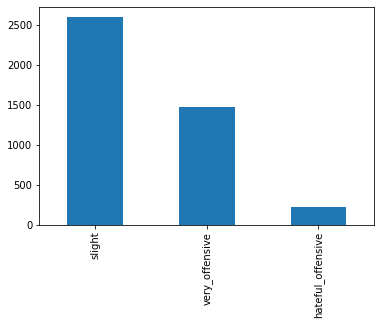

In [66]:
df_c.offensive.value_counts().plot(kind='bar')

In [67]:
df_c

,text_corrected,offensive
3,image 4 png,very_offensive
4,image 5 png,very_offensive
5,image 6 jpg,slight
8,image 9 jpg,slight
9,image 10 png,slight
...,...,...
6982,image 6983 jpg,very_offensive
6983,image 6984 jpg,slight
6984,image 6985 jpg,hateful_offensive
6987,image 6988 jpg,very_offensive


In [68]:
vld=df_c[df_c['offensive']=='hateful_offensive']
vld.append(df_c.head(100))

,text_corrected,offensive
148,image 149 png,hateful_offensive
202,image 203 jpg,hateful_offensive
213,image 214 jpg,hateful_offensive
331,image 332 jpg,hateful_offensive
365,image 366 jpg,hateful_offensive
...,...,...
184,image 185 jpg,slight
185,image 186 jpg,slight
188,image 189 jpg,slight
190,image 191 jpg,slight


In [69]:
#Binary Training
data_f=pd.DataFrame(df_c, columns = ['text_corrected', 'binary'])

data_f = data_f.rename(columns={"text_corrected":"text", "binary":"label"})


data_f['label'] = '__label__' + data_f['label'].astype(str)
data_f.to_csv('bin2nt.txt', sep='\t', index = False, header = False)



two_train_data=os.getcwd()+'/bin2nt.txt'
print(two_train_data)

/Users/askvyas/Documents/Memes/bin2nt.txt


/Users/askvyas/Documents/Memes/bin_2n.train.txt


In [47]:
f = open('/Users/askvyas/Documents/wiki-news-300d-1M.vec', encoding = 'utf8')


In [48]:
hyper_params = {"lr": 0.01,
                        "epoch": 20,
                        "wordNgrams": 2,
                        "dim": 300,
               "pretrainedVectors":'/Users/askvyas/Documents/wiki-news-300d-1M.vec'
               }


model_bin = fasttext.train_supervised(input=two_train_data, **hyper_params)



In [49]:
result = model_bin.test(two_train_data)
validation = model_bin.test(two_test_data)
# DISPLAY ACCURACY OF TRAINED MODEL
text_line = "accuracy:" + str(result[1])  + ",validation:" + str(validation[1]) + '\n' 
print(text_line)


accuracy:1.0,validation:1.0



In [50]:
validation

(221, 1.0, 1.0)

In [51]:
### Create sequence
df_c['text_corrected']=df_c['text_corrected'].astype(str)
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df_c['text_corrected'])
sequences = tokenizer.texts_to_sequences(df_c['text_corrected'])
data = pad_sequences(sequences, maxlen=50)

In [52]:
f = open('/Users/askvyas/Documents/wiki-news-300d-1M.vec', encoding = 'utf8')



In [53]:
embeddings_index = dict()
for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [54]:
embedding_matrix = np.zeros((20000, 300))
for word, index in tokenizer.word_index.items():
    if index > 20000 - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [55]:
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 300, input_length=50, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
print(embedding_matrix.shape)
print(data.shape)

(20000, 300)
(4279, 50)


In [58]:
labels=df_c.offensive.map(lambda x:0 if x=='not_offensive' else 1)